In [1]:
# Install necessary libraries
# pip install  transformers 
# pip install seqeval
#!pip install datasets


In [2]:
#pip install  transformers

In [3]:
#pip install seqeval

In [4]:
#pip install --upgrade pyarrow

In [5]:
#pip install --upgrade datasets

In [4]:
#pip install ipywidgets
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

In [5]:
from datasets import load_dataset

# Allow execution of custom code in the dataset repository
dataset = load_dataset('ncbi_disease', trust_remote_code=True)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [7]:
# View dataset splits
print(dataset)

# Access the training set
train_dataset = dataset['train']

# View an example
print(train_dataset[0])

# Check label names
label_list = train_dataset.features['ner_tags'].feature.names
print("Label List:", label_list)

# Number of labels
num_labels = len(label_list)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})
{'id': '0', 'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}
Label List: ['O', 'B-Disease', 'I-Disease']


In [9]:
# Data Preprocessing and Tokenization

In [8]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] != 0 else 0)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

In [11]:
# Model Development

In [12]:
#%pip install tf-keras

In [13]:
#pip install torch torchvision torchaudio

In [9]:
import torch
print(torch.__version__)

2.5.1+cpu


In [15]:
#pip install transformers[torch]

In [16]:
#pip install accelerate>=0.26.0

In [10]:
import tensorflow as tf

In [11]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Load a pre-trained model for token classification
model = AutoModelForTokenClassification.from_pretrained('bert-base-cased', num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Define data collator
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\s.diedhiou\AppData\Local\anaconda3\envs\my_conda_env_with_py311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
# Model Training

In [20]:
#pip install evaluate

In [21]:
#%pip install comet_ml

In [12]:
#pip install evaluate
import evaluate

In [23]:
#import comet_ml
#import tensorflow as tf
#from keras.models import Sequential

In [24]:
#pip install wandb

In [29]:
#!pip install --upgrade wandb

In [13]:
import wandb
print(wandb.__version__)

0.18.7


In [14]:
import numpy as np
#from datasets import load_metric

# Load evaluation metric
metric = evaluate.load('seqeval')

# Define compute_metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': results['overall_precision'],
        'recall': results['overall_recall'],
        'f1': results['overall_f1'],
        'accuracy': results['overall_accuracy'],
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

C:\Users\s.diedhiou\AppData\Local\Temp\ipykernel_17960\3390373823.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: salioudiedhiou (salioudiedhiou-sd-consolidated-accuracy). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.072500,0.071608,0.784131,0.819512,0.801431,0.977032
2,0.036800,0.072481,0.804299,0.867073,0.834507,0.979584
3,0.022800,0.081544,0.819113,0.878049,0.847557,0.979958


TrainOutput(global_step=1020, training_loss=0.07282484641992579, metrics={'train_runtime': 14554.4853, 'train_samples_per_second': 1.12, 'train_steps_per_second': 0.07, 'total_flos': 1064728585569024.0, 'train_loss': 0.07282484641992579, 'epoch': 3.0})

In [ ]:
# Model Evaluation

In [15]:
# Evaluate on the test set
test_results = trainer.evaluate(tokenized_datasets['test'])

# Print evaluation results
print(test_results)

{'eval_loss': 0.09352871030569077, 'eval_precision': 0.8453478625314333, 'eval_recall': 0.8862038664323374, 'eval_f1': 0.8652938652938653, 'eval_accuracy': 0.9751043620303709, 'eval_runtime': 137.2193, 'eval_samples_per_second': 6.858, 'eval_steps_per_second': 0.43, 'epoch': 3.0}


In [ ]:
true_labels = train_dataset.features['ner_tags'].feature.names

In [16]:
# Get predictions
predictions, labels, _ = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(predictions, axis=2)

# Extract true labels and predictions
true_labels = [
    [label_list[l] for l in label if l != -100]
    for label in labels
]
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Analyze errors
#for i in range(len(true_predictions)):
  #  for j in range(len(true_predictions[i])):
    #    if true_predictions[i][j] != true_labels[i][j]:
       #     token = tokenized_datasets['test']['tokens'][i][j]
       #     print(f"Token: {token}, True Label: {true_labels[i][j]}, Predicted Label: {true_predictions[i][j]}")

for i in range(len(true_predictions)):
    for j in range(min(len(true_predictions[i]), len(true_labels[i]), len(tokenized_datasets['test']['tokens'][i]))):
        if true_predictions[i][j] != true_labels[i][j]:
            token = tokenized_datasets['test']['tokens'][i][j]
            print(f"Token: {token}, True Label: {true_labels[i][j]}, Predicted Label: {true_predictions[i][j]}")

Token: in, True Label: B-Disease, Predicted Label: O
Token: ATM, True Label: B-Disease, Predicted Label: O
Token: mutations, True Label: I-Disease, Predicted Label: B-Disease
Token: PLL, True Label: B-Disease, Predicted Label: O
Token: samples, True Label: I-Disease, Predicted Label: O
Token: had, True Label: I-Disease, Predicted Label: O
Token: a, True Label: I-Disease, Predicted Label: O
Token: establishes, True Label: O, Predicted Label: B-Disease
Token: somatic, True Label: O, Predicted Label: B-Disease
Token: this, True Label: B-Disease, Predicted Label: I-Disease
Token: a, True Label: B-Disease, Predicted Label: O
Token: tumour, True Label: B-Disease, Predicted Label: O
Token: unilateral, True Label: O, Predicted Label: B-Disease
Token: retinoblastoma, True Label: B-Disease, Predicted Label: I-Disease
Token: isolated, True Label: O, Predicted Label: B-Disease
Token: unilateral, True Label: B-Disease, Predicted Label: I-Disease
Token: retinoblastoma, True Label: B-Disease, Predict

In [23]:
print(len(true_labels))
print(len(true_predictions))

33058
29171


In [24]:
true_predictions = [
    label_list[p] for prediction in predictions for p, l in zip(prediction, labels[0]) if l != -100
]
print(len(true_predictions))  # Check the length of true_predictions

29171


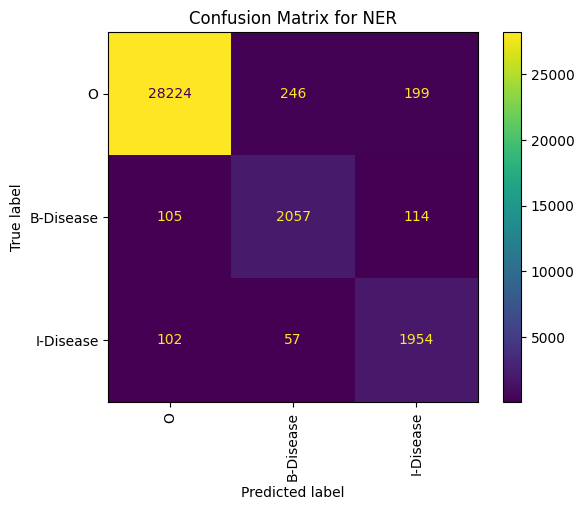

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions, labels, _ = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(predictions, axis=2)  # Convert logits to label indices

# Flatten the predictions and labels, ignoring special tokens (-100)
true_labels = []
true_predictions = []

for label_seq, pred_seq in zip(labels, predictions):
    for label, pred in zip(label_seq, pred_seq):
        if label != -100:  # Ignore special tokens
            true_labels.append(label_list[label])  # Add the true label (use label_list to map)
            true_predictions.append(label_list[pred])  # Add the predicted label (use label_list to map)

# Generate confusion matrix
cm = confusion_matrix(true_labels, true_predictions, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

# Plot the confusion matrix
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for NER")
plt.show()



In [31]:
# Classification report
report = classification_report(true_labels, true_predictions, target_names=label_list)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           O       0.87      0.90      0.89      2276
   B-Disease       0.86      0.92      0.89      2113
   I-Disease       0.99      0.98      0.99     28669

    accuracy                           0.98     33058
   macro avg       0.91      0.94      0.92     33058
weighted avg       0.98      0.98      0.98     33058



In [21]:
#pip install matplotlib

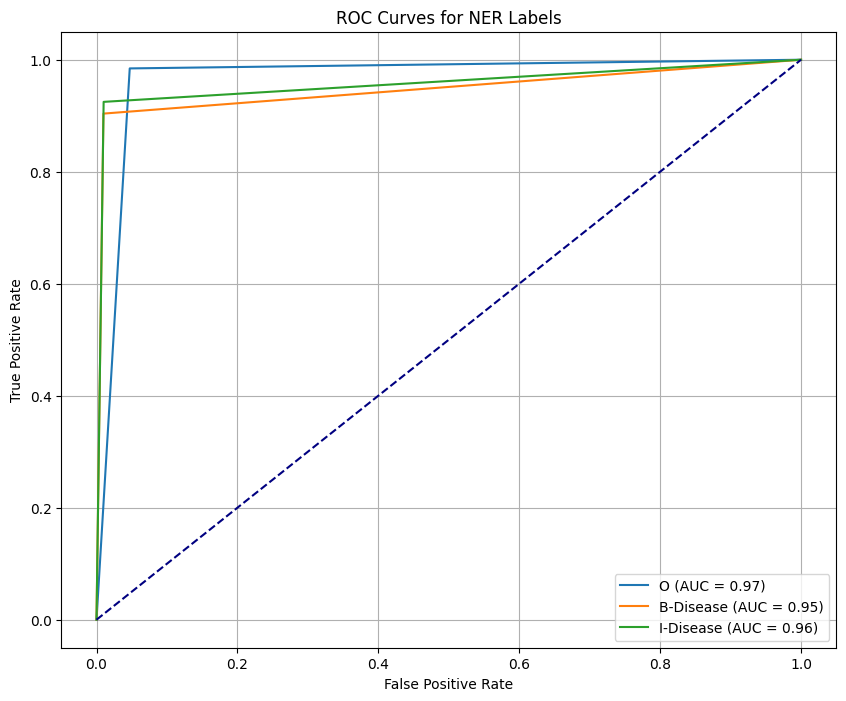

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Assuming you already have the following:
# - `predictions` (probabilities) from the model
# - `labels` (true labels) from the dataset
# - `label_list` (all possible NER labels)

# Get the predicted probabilities (not the argmax) - assuming `predictions` is logits
predictions = np.array(predictions)  # logits output from the model
predictions_prob = np.exp(predictions) / np.sum(np.exp(predictions), axis=-1, keepdims=True)  # Apply softmax

# Binarize the true labels for each token (i.e., One-hot encoding for multi-class labels)
# Flattening the labels and predictions while ignoring padding (-100)
true_labels = []
true_predictions = []
for label_seq, pred_seq in zip(labels, predictions):
    for label, pred in zip(label_seq, pred_seq):
        if label != -100:  # Ignore special tokens
            true_labels.append(label)  # True label (in class indices)
            true_predictions.append(pred)  # Predicted probability (softmax outputs)

# Binarize the true labels to One-hot encoding
true_labels_bin = label_binarize(true_labels, classes=range(len(label_list)))  # Binary matrix for true labels
predictions_bin = label_binarize(true_predictions, classes=range(len(label_list)))  # Binary matrix for predictions

# Initialize the ROC curve plot
plt.figure(figsize=(10, 8))

# Calculate ROC curve for each label
for i in range(len(label_list)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predictions_bin[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot each ROC curve
    plt.plot(fpr, tpr, label=f'{label_list[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guessing curve)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labeling and formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for NER Labels')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Error Analysis and Model Improvement

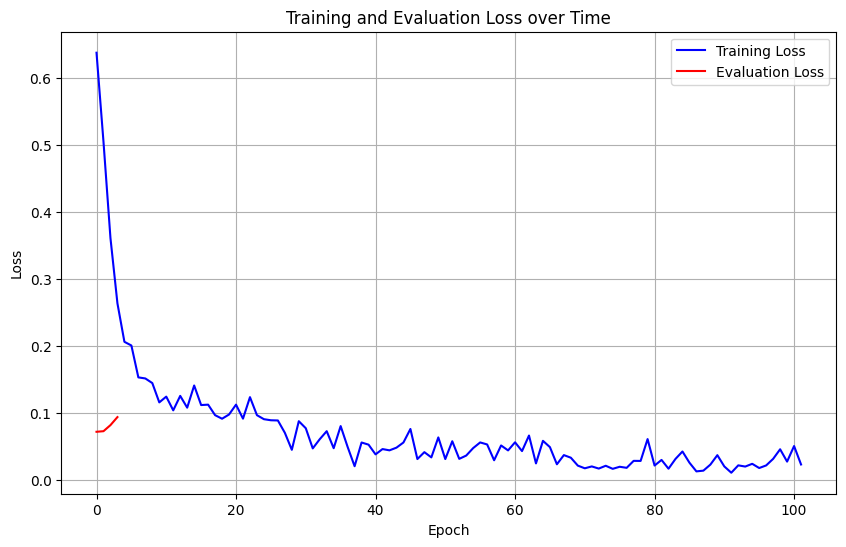

In [35]:
import matplotlib.pyplot as plt

# Access the training and evaluation loss from the trainer's log history
train_losses = []
eval_losses = []

# Loop through the log history to extract loss values
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])  # Training loss
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])  # Evaluation loss

# Plot the training and evaluation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss over Time')
plt.legend()
plt.grid(True)
plt.show()
